In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset("/global/cfs/cdirs/m4746/Users/nora/ucla-roms/Examples/CDR/cdr_release.nc")

In [3]:
ds

<xarray.Dataset> Size: 808B
Dimensions:     (ncdr: 1, time: 12, ntracers: 3)
Dimensions without coordinates: ncdr, time, ntracers
Data variables:
    cdr_lon     (ncdr) float64 8B ...
    cdr_lat     (ncdr) float64 8B ...
    cdr_hsc     (ncdr) float64 8B ...
    cdr_vsc     (ncdr) float64 8B ...
    cdr_dep     (ncdr) float64 8B ...
    cdr_time    (time) float64 96B ...
    cdr_volume  (time, ncdr) float64 96B ...
    cdr_tracer  (time, ntracers, ncdr) float64 288B ...
    cdr_trcflx  (time, ntracers, ncdr) float64 288B ...

In [5]:
ds.cdr_lon.values

array([-120.718])

In [6]:
ds.cdr_lat.values

array([34.56])

In [7]:
ds.cdr_hsc.values

array([5000.])

In [8]:
ds.cdr_vsc.values

array([10.])

In [27]:
ds.cdr_dep.values

array([20.])

In [9]:
ds.cdr_time.values

array([ 15.,  45.,  75., 105., 135., 165., 195., 225., 255., 285., 315.,
       345.])

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Volume flux (m3/s)')

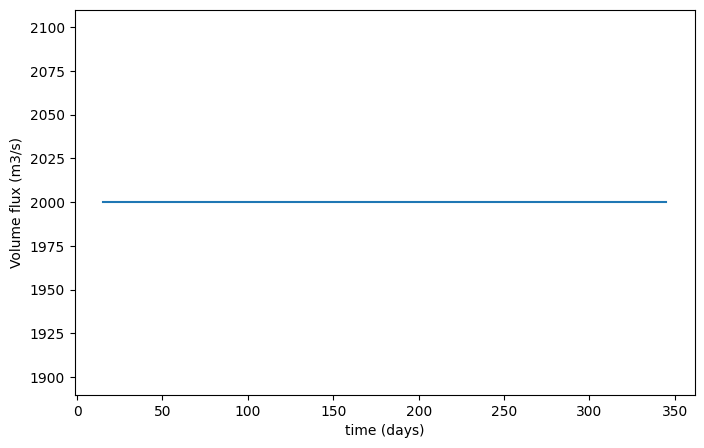

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_volume.values)
ax.set_xlabel("time (days)")
ax.set_ylabel("Volume flux (m3/s)")

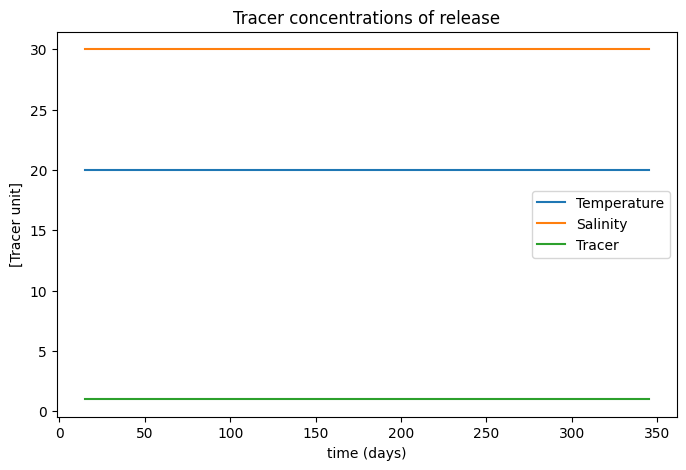

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=0).values, label="Temperature")
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=1).values, label="Salinity")
ax.plot(ds.cdr_time.values, ds.cdr_tracer.isel(ntracers=2).values, label="Tracer")
ax.set_xlabel("time (days)")
ax.set_ylabel("[Tracer unit]")
ax.set_title("Tracer concentrations of release")
ax.legend()

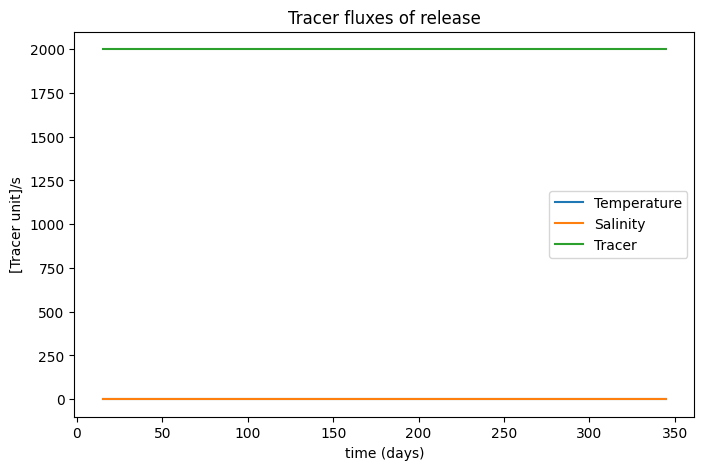

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=0).values, label="Temperature")
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=1).values, label="Salinity")
ax.plot(ds.cdr_time.values, ds.cdr_trcflx.isel(ntracers=2).values, label="Tracer")
ax.set_xlabel("time (days)")
ax.set_ylabel("[Tracer unit]/s")
ax.set_title("Tracer fluxes of release")
ax.legend()

In [36]:
ds.cdr_trcflx.isel(ntracers=0).values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [37]:
ds.cdr_trcflx.isel(ntracers=1).values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
@dataclass(frozen=True, kw_only=True)
class CDRForcing:
    """Represents river forcing input data for ROMS.

    Parameters
    ----------
    grid : Grid, optional
        Object representing the grid information.
    lat :
        Latitude of CDR release.
    lon :
        Lon of CDR release.
    depth :
        Depth of CDR release.
    sigma_x :
    sigma_y :
    sigma_z :
    times : times with dates
    volume : time series of volumes
    
    temp: time series with temperature of 
    
    start_time : datetime
        Start time of the desired river forcing data.
    end_time : datetime
        End time of the desired river forcing data.
    model_reference_date : datetime, optional
        Reference date for the model. Default is January 1, 2000.
        
    Attributes
    ----------
    ds : xr.Dataset
        The xarray Dataset containing the river forcing data.
    """

    grid: Optional[Grid]
    start_time: datetime
    end_time: datetime
    model_reference_date: datetime = datetime(2000, 1, 1)

    ds: xr.Dataset = field(init=False, repr=False)

    def __post_init__(self):
        self._input_checks()

        ds = self._create_river_forcing(data)
        ds = self._write_indices_into_dataset(ds)
        self._validate(ds)

        for var_name in ds.data_vars:
            ds[var_name] = substitute_nans_by_fillvalue(ds[var_name], fill_value=0.0)

        object.__setattr__(self, "ds", ds)


    def _create_river_forcing(self, data):
        """Create river forcing data for volume flux and tracers (temperature, salinity,
        BGC tracers).

        This method computes the river volume flux and associated tracers (temperature, salinity, BGC tracers)
        based on the provided input data. It generates a new `xarray.Dataset` that contains:
        - `river_volume`: The river volume flux, calculated as the product of river flux and a specified ratio, with units of m³/s.
        - `river_tracer`: A tracer array containing temperature, salinity, and BGC tracer values for each river over time.

        The method also handles climatological adjustments for missing or incomplete data, depending on the `convert_to_climatology` setting.

        Parameters
        ----------
        data : object
            An object containing the necessary dataset and variables for river forcing creation. The object must have the following attributes:
            - `ds`: The dataset containing the river flux, ratio, and other related variables.
            - `var_names`: A dictionary mapping variable names (e.g., `"flux"`, `"ratio"`, `"name"`) to the corresponding variable names in the dataset.
            - `dim_names`: A dictionary mapping dimension names (e.g., `"time"`, `"station"`) to the corresponding dimension names in the dataset.

        Returns
        -------
        xr.Dataset
            A new `xarray.Dataset` containing the computed river forcing data. The dataset includes:
            - `river_volume`: A `DataArray` representing the river volume flux (m³/s).
            - `river_tracer`: A `DataArray` representing tracer data for temperature, salinity and BGC tracers (if specified) for each river over time.
        """

        ds = xr.Dataset()

        river_volume = (
            data.ds[data.var_names["flux"]] * data.ds[data.var_names["ratio"]]
        ).astype(np.float32)
        river_volume.attrs["long_name"] = "River volume flux"
        river_volume.attrs["units"] = "m^3/s"
        river_volume = river_volume.rename(
            {data.dim_names["time"]: "river_time", data.dim_names["station"]: "nriver"}
        )
        name = data.ds[data.var_names["name"]].rename(
            {data.dim_names["station"]: "nriver"}
        )
        name.attrs["long_name"] = "River name"
        river_volume.coords["river_name"] = name

        ds["river_volume"] = river_volume

        nriver = xr.DataArray(np.arange(1, len(ds.nriver) + 1), dims="nriver")
        nriver.attrs["long_name"] = "River ID (1-based Fortran indexing)"
        ds = ds.assign_coords({"nriver": nriver})

        if self.include_bgc:
            ntracers = 2 + 32
        else:
            ntracers = 2
        tracer_data = np.zeros(
            (len(ds.river_time), ntracers, len(ds.nriver)), dtype=np.float32
        )
        tracer_data[:, 0, :] = 17.0
        tracer_data[:, 1, :] = 1.0
        tracer_data[:, 2:, :] = 0.0

        river_tracer = xr.DataArray(
            tracer_data, dims=("river_time", "ntracers", "nriver")
        )
        river_tracer.attrs["long_name"] = "River tracer data"

        if self.include_bgc:
            tracer_names = xr.DataArray(
                [
                    "temp",
                    "salt",
                    "PO4",
                    "NO3",
                    "SiO3",
                    "NH4",
                    "Fe",
                    "Lig",
                    "O2",
                    "DIC",
                    "DIC_ALT_CO2",
                    "ALK",
                    "ALK_ALT_CO2",
                    "DOC",
                    "DON",
                    "DOP",
                    "DOPr",
                    "DONr",
                    "DOCr",
                    "zooC",
                    "spChl",
                    "spC",
                    "spP",
                    "spFe",
                    "spCaCO3",
                    "diatChl",
                    "diatC",
                    "diatP",
                    "diatFe",
                    "diatSi",
                    "diazChl",
                    "diazC",
                    "diazP",
                    "diazFe",
                ],
                dims="ntracers",
            )
        else:
            tracer_names = xr.DataArray(["temp", "salt"], dims="ntracers")
        tracer_names.attrs["long_name"] = "Tracer name"
        river_tracer.coords["tracer_name"] = tracer_names
        ds["river_tracer"] = river_tracer

        ds, time = convert_to_roms_time(
            ds, self.model_reference_date, self.climatology, time_name="river_time"
        )

        ds = ds.assign_coords({"river_time": time})

        return ds
